## 10. Entrenamiento de la Red Neuronal Convolucional (CNN)

Aunque Spark MLlib ofrece algoritmos de aprendizaje automático integrados y distribuidos, **no está diseñado para trabajar con redes neuronales profundas como las CNN**. Las capacidades de MLlib se centran en modelos más clásicos como la regresión logística y lineal, árboles de decisión y bosques aleatorios, clustering (K-means), redes neuronales multicapa simples (perceptrones), ...)

En este caso utilizamos **TensorFlowOnSpark (TFoS)**  para entrenar una red neuronal convolucional (CNN) en un clúster Spark. De este modo, se puede ejecutar código de TensorFlow de forma distribuida sobre Spark.

Este enfoque es necesario porque entrenar modelos con grandes volúmenes de datos (como miles de posiciones FEN) puede superar la capacidad de memoria y procesamiento de una sola máquina. TFoS permite repartir tanto los datos como el entrenamiento entre múltiples nodos del clúster, manteniendo compatibilidad con APIs estándar de TensorFlow.

La función `entrenar_cnn()` encapsula este proceso para reutilizarlo en los dos conjuntos de datos: partidas jugadas con blancas y con negras. Internamente:
- Se define una arquitectura CNN simple para clasificar jugadas según la posición del tablero.
- Se cargan y preparan los datos desde Parquet.
- El entrenamiento se lanza distribuido con `TFCluster.run()`, donde cada nodo ejecuta una copia del modelo entrenando en paralelo.

In [1]:
def entrenar_cnn(data_path, model_path):
    import numpy as np
    import tensorflow as tf
    from pyspark.sql import SparkSession
    from tensorflowonspark import TFCluster

    from sklearn.model_selection import train_test_split

    spark = SparkSession.builder \
        .appName("TFoS-CNN") \
        .master("local[2]") \
        .config("spark.driver.memory", "2g") \
        .getOrCreate()
    sc = spark.sparkContext

    # Leer todos los datos EN EL DRIVER
    df = spark.read.parquet(data_path)
    features = df.select("features").rdd.map(lambda r: r[0]).collect()
    labels = df.select("label").rdd.map(lambda r: int(r[0])).collect()

    # Convertir en arrays numpy y particionar manualmente
    X = np.array(features).reshape(-1, 8, 8, 12)
    y = np.array(labels, dtype=np.int32)

    num_workers = 2  # Debe coincidir con num_executors
    partitions = [(X[i::num_workers], y[i::num_workers]) for i in range(num_workers)]

    # Argumentos que recibe cada worker (ya separados)
    args = {
        "data": partitions,
        "model_path": model_path
    }

    # Modelo CNN
    def model_fn(num_classes):
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(8, 8, 12)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    # Función que corre en cada worker
    def main_fun(args, ctx):
        import tensorflow as tf
        from sklearn.model_selection import train_test_split
        import numpy as np

        X, y = args["data"][ctx.worker_num]  # Cada worker toma su partición

        num_classes = np.max(y) + 1
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

        model = model_fn(num_classes)
        history = model.fit(
            X_train, y_train,
            epochs=8,
            validation_data=(X_test, y_test),
            batch_size=32
        )


        if ctx.job_name == "chief":
            print(f"[CHIEF] Soy el chief (worker {ctx.worker_num})")
        
            # Guardar el modelo
            model.save(args["model_path"])
            print(f"[CHIEF] Modelo guardado en: {args['model_path']}")
        
            # Guardar el historial
            try:
                print(f"[CHIEF] Intentando guardar historial en: {args['model_path']}_history.pkl")
                import pickle
                with open(args["model_path"] + "_history.pkl", "wb") as f:
                    pickle.dump(history.history, f)
                print("[CHIEF] Historial guardado correctamente")
            except Exception as e:
                print(f"[CHIEF] Error al guardar historial: {e}")


    # Ejecutar el entrenamiento distribuido
    cluster = TFCluster.run(
        sc,
        main_fun,
        args,
        num_executors=num_workers,
        num_ps=1,
        input_mode=TFCluster.InputMode.TENSORFLOW,
        master_node="chief",
        log_dir="/tmp/tf_logs"
    )

In [2]:
## Pongo el destino en local para pruebas (no ocupa mucho)
entrenar_cnn(
    data_path="hdfs:///user/ajedrez/datos_cnn/blancas/fen_jugadas.parquet",
    model_path="/notebooks/datos_cnn/modelo_blancas"
)

2025-07-13 10:48:10.177958: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-13 10:48:10.585053: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-13 10:48:10.588269: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-13 10:48:12.597081: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/13 10:48:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2025-07-13 10:49:06

In [ ]:
## IMPORTANTE: REINICIAR EL KERNEL
## Ejecutar la celda de la función "entrenar_cnn" y luego la siguiente, el modelo para negras

In [2]:
# Modelo para negras
entrenar_cnn(
    data_path="hdfs:///user/ajedrez/datos_cnn/negras/fen_jugadas.parquet",
    model_path="/notebooks/datos_cnn/modelo_negras"
)

2025-06-26 15:23:29.416882: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-26 15:23:29.466380: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-26 15:23:29.467057: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-26 15:23:30.443249: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/26 15:23:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2025-06-26 15:23:54

In [3]:
!ls -l /notebooks/datos_cnn/modelo_blancas/
#!ls -l /notebooks/datos_cnn/modelo_negras/

IOStream.flush timed out
total 128
drwxr-xr-x 2 1000 1000   4096 May 11 20:45 assets
-rw-r--r-- 1 root root     56 Jul 13 10:51 fingerprint.pb
-rw-r--r-- 1 1000 1000  11668 Jul 13 10:51 keras_metadata.pb
-rw-r--r-- 1 root root 102885 Jul 13 10:51 saved_model.pb
drwxr-xr-x 2 1000 1000   4096 Jul 13 10:51 variables


## 11. Evaluación del entrenamiento. Precisión Top-k (blancas)

2025-07-13 10:51:37,477 INFO (MainThread-25) generated new fontManager
2025-07-13 10:51:37,719 INFO (Thread-5-25) Error while sending or receiving.
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/py4j/clientserver.py", line 503, in send_command
    self.socket.sendall(command.encode("utf-8"))
ConnectionResetError: [Errno 104] Connection reset by peer
2025-07-13 10:51:37,739 INFO (Thread-5-25) Closing down clientserver connection
2025-07-13 10:51:37,740 INFO (Thread-5-25) Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/py4j/clientserver.py", line 503, in send_command
    self.socket.sendall(command.encode("utf-8"))
ConnectionResetError: [Errno 104] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = c

Métricas disponibles en el historial: ['loss', 'accuracy', 'val_loss', 'val_accuracy']


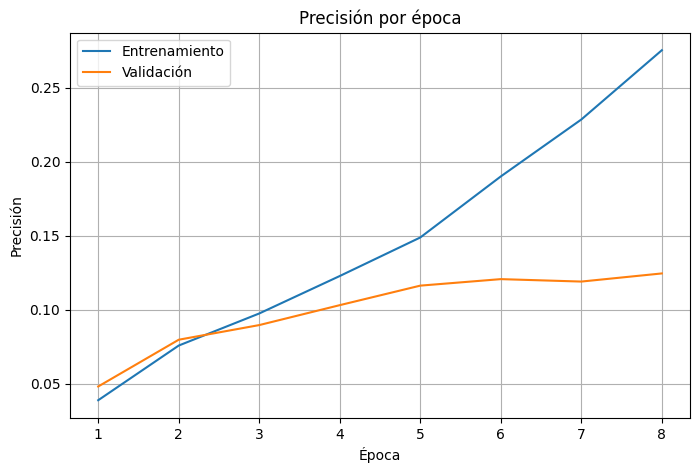

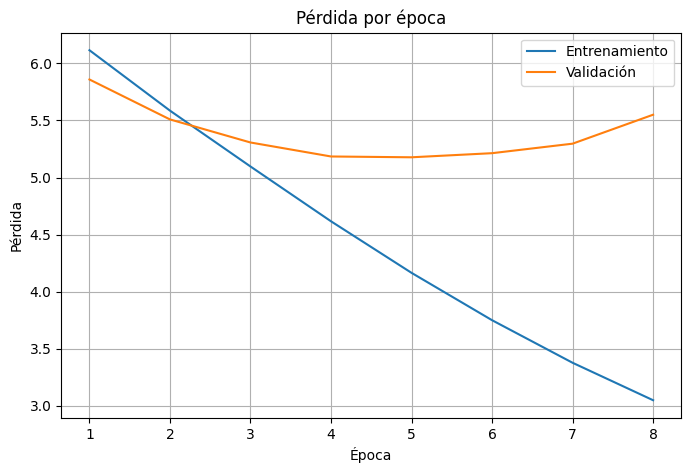

In [4]:
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np

# Rutas al modelo y al historial (ajusta si es necesario)
model_path = "/notebooks/datos_cnn/modelo_blancas"
history_path = model_path + "_history.pkl"

# Cargar historial
with open(history_path, "rb") as f:
    history = pickle.load(f)

# Mostrar claves disponibles (opcional)
print("Métricas disponibles en el historial:", list(history.keys()))

# Crear vector de épocas comenzando en 1
epochs = range(1, len(history["accuracy"]) + 1)

# Graficar precisión
plt.figure(figsize=(8, 5))
plt.plot(epochs, history["accuracy"], label="Entrenamiento")
plt.plot(epochs, history["val_accuracy"], label="Validación")
plt.title("Precisión por época")
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.legend()
plt.grid(True)
plt.savefig("precision.png")   
plt.show()

# Graficar pérdida
plt.figure(figsize=(8, 5))
plt.plot(epochs, history["loss"], label="Entrenamiento")
plt.plot(epochs, history["val_loss"], label="Validación")
plt.title("Pérdida por época")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True)
plt.savefig("perdida.png") 
plt.savefig(model_path + "_grafica_perdida.png") 
plt.show()


25/07/13 10:51:43 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
[Stage 3:=============================>                             (1 + 1) / 2]

228/228 [==============================] - 1s 3ms/step
Top-3 accuracy: 38.71%
Top-5 accuracy: 46.43%
Top-7 accuracy: 51.79%


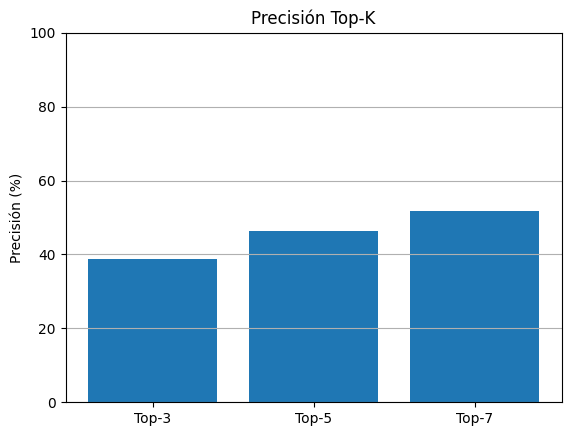

In [5]:
import numpy as np
import pickle
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pyspark.sql import SparkSession

# --- Rutas ---
model_path = "/notebooks/datos_cnn/modelo_blancas"
history_path = model_path + "_history.pkl"
data_path = "hdfs:///user/ajedrez/datos_cnn/blancas/fen_jugadas.parquet"

# --- Cargar modelo y historial ---
model = load_model(model_path)

with open(history_path, "rb") as f:
    history = pickle.load(f)

# --- Cargar datos desde HDFS con Spark ---
spark = SparkSession.builder \
    .appName("CargarDatosTest") \
    .master("local[2]") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

df = spark.read.parquet(data_path)

# Extraer features y labels al driver
features = df.select("features").rdd.map(lambda r: r[0]).collect()
labels = df.select("label").rdd.map(lambda r: int(r[0])).collect()

# Convertir a NumPy
X = np.array(features).reshape(-1, 8, 8, 12)
y = np.array(labels, dtype=np.int32)

# Separar conjunto de test
_, X_test, _, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# --- Predicciones ---
y_pred = model.predict(X_test)
num_classes = y_pred.shape[1]

# --- Función top-k accuracy ---
def top_k_accuracy(y_true, y_pred, k=5):
    top_k_preds = np.argsort(y_pred, axis=1)[:, -k:]
    return np.mean([y_true[i] in top_k_preds[i] for i in range(len(y_true))])

# --- Imprimir resultados top-k ---
for k in [3, 5, 7]:
    acc = top_k_accuracy(y_test, y_pred, k=k)
    print(f"Top-{k} accuracy: {acc*100:.2f}%")

# --- Visualización ---
accuracies = [top_k_accuracy(y_test, y_pred, k=k)*100 for k in [3, 5, 7]]
plt.bar(["Top-3", "Top-5", "Top-7"], accuracies)
plt.title("Precisión Top-K")
plt.ylabel("Precisión (%)")
plt.ylim(0, 100)
plt.grid(True, axis='y')
plt.savefig("topk_accuracy.png")
plt.show()


## 12. Juega contra Nakamura

Este entorno de juego implementa una partida de ajedrez entre un jugador humano y un jugador artificial llamado "Nakamura". El bot ha sido entrenado para jugar tanto con blancas como con negras. El objetivo del bot no es solo ganar la partida, sino hacerlo **imitando su estilo humano**.

El bot toma sus decisiones combinando la potencia táctica de **Stockfish** con una **red neuronal convolucional entrenada** sobre partidas reales. La lógica interna sigue este flujo:

1. **Evaluación de la posición (Stockfish).** A partir de la posición actual en formato FEN, Stockfish (parámetros similares a los de nuestro jugador real `ELO = 2800` y `habilidad = 20`) genera una lista de las mejores jugadas disponibles `(top_n=10)`, cada una con su evaluación (en centipawns o con amenaza de mate).

2. **Intervención de la red neuronal.** La posición del tablero se transforma en un tensor de dimensiones `(8, 8, 12)`, que representa cada pieza en cada casilla como un plano de activación. El modelo evalúa todas las posibles jugadas y asigna una puntuación aprendida durante el entrenamiento. De entre las jugadas razonables (filtradas por Stockfish), se elige aquella con **mayor puntuación de la red neuronal**.

3. **Ejecución del movimiento:**
   - Si hay una única jugada claramente superior, se ejecuta directamente. Por ejemplo, comer una ficha importante por despiste del rival.
   - En caso de varias buenas opciones, se prioriza la que la IA considera más representativa del "estilo Nakamura".
   - La opción elegida en cada caso se muestra durante la partida junto con su notación algebraica.

La red neuronal no reemplaza a Stockfish, sino que **lo complementa**. Mientras el motor garantiza que las jugadas sean sólidas, la IA aporta personalidad: **elige entre varias jugadas buenas aquella que se parece más a un humano**. Esto hace que el bot no solo busque precisión, sino que lo haga con una estrategia y fluidez más natural, más impredecible, más creativa.

<span style="color:blue"> 

Ahora hay que:
- Bajar los contenedores: `docker compose down`
- En el host de Linux, fuera de los contenedores: `xhost +local:root` Otra opción es acordarse de ejecutarlo antes de levantar los contenedores siempre.
- Subir los contenedores: `docker compose up -d`
- Ejecutar las siguientes celdas.
</span>

In [6]:
!pip install pygame

IOStream.flush timed out
     |████████████████████████████████| 14.0 MB 1.2 MB/s eta 0:00:01


In [7]:
# Instalar el wrapper de Python para Stockfish pero también se necesita el binario ejecutable en el sistema
!pip install stockfish

[Stage 3:=============================>                             (1 + 1) / 2]

IOStream.flush timed out


In [ ]:
# INSTALACION DEL EJECUTABLE ( solo una vez, luego se queda en la carpeta /notebooks/motor_ejecutable )
# Desde el bash de spark-client:

#cd /notebooks
#rm -rf Stockfish
#git clone --branch sf_15 https://github.com/official-stockfish/Stockfish.git
#cd Stockfish/src
#make build ARCH=x86-64
#mkdir -p /notebooks/motor_ejecutable
#cp stockfish /notebooks/motor_ejecutable/stockfish
#chmod +x /notebooks/motor_ejecutable/stockfish

[Stage 0:=============================>                             (1 + 1) / 2]

In [8]:
# Instalar comunicación X11 
!apt update && apt install -y x11-utils x11-xserver-utils x11-apps

IOStream.flush timed out
Hit:1 http://deb.debian.org/debian bullseye InRelease
Get:2 http://deb.debian.org/debian-security bullseye-security InRelease [27.2 kB]
Get:3 http://deb.debian.org/debian bullseye-updates InRelease [44.0 kB]
Get:4 http://deb.debian.org/debian-security bullseye-security/main amd64 Packages [384 kB]
Fetched 455 kB in 1s (546 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
71 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  bsdextrautils groff-base libdrm-amdgpu1 libdrm-common libdrm-intel1
  libdrm-nouveau2 libdrm-radeon1 libdrm2 libelf1 libfontenc1 libgl1
  libgl1-mesa-dri libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libice6
  libllvm11 libpciaccess0 libpipeline1 libsensors-config libsensors5 libsm6
  libuchardet0 libvulkan1 libwayland-clien

[Stage 3:=============================>                             (1 + 1) / 2]

Setting up libxt6:amd64 (1:1.2.0-1) ...
7Progress: [ 93%] [######################################################....] 8Setting up libxmu6:amd64 (2:1.1.2-2+b3) ...
7Progress: [ 94%] [######################################################....] 8Setting up libglx-mesa0:amd64 (20.3.5-1) ...
Setting up libglx0:amd64 (1.3.2-1) ...
7Progress: [ 95%] [#######################################################...] 8Setting up libxaw7:amd64 (2:1.0.13-1.1) ...
7Progress: [ 96%] [#######################################################...] 8Setting up x11-xserver-utils (7.7+8) ...
7Progress: [ 97%] [########################################################..] 8Setting up libgl1:amd64 (1.3.2-1) ...
7Progress: [ 98%] [########################################################..] 8Setting up x11-utils (7.7+5) ...
Setting up x11-apps (7.7+8) ...
7Progress: [ 99%] [#########################################################.] 8Processing triggers for libc-bin (2.31-13+deb11u3) ...

78

### 12.1 Nakamura juega con blancas
Incluye el giro de tablero y reestructuración de la notación. Para jugar hacer clic en pieza que se quiere mover y clic en la casilla destino de la pieza.

In [9]:
import pygame
import chess
import numpy as np
from tensorflow.keras.models import load_model
from stockfish import Stockfish
import os

# --- CONFIGURACIÓN ---
MODEL_PATH = "/notebooks/datos_cnn/modelo_blancas"
STOCKFISH_PATH = "motor_ejecutable/stockfish"
ENCODER_PATH = "encoder_blancas.npy"  # Guardado tras el entrenamiento

# Inicializar pygame
pygame.init()
WIDTH, HEIGHT = 800, 800
SQ_SIZE = WIDTH // 8
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Juega contra Nakamura")

# Cargar imágenes con rutas absolutas
BASE_DIR = os.getcwd()
PIECE_DIR = os.path.join(BASE_DIR, "pieces")

PIECE_IMAGES = {}
PIECE_MAPPING = {
    "r": "R1", "n": "N1", "b": "B1", "q": "Q1", "k": "K1", "p": "P1",
    "R": "R", "N": "N", "B": "B", "Q": "Q", "K": "K", "P": "P"
}
for symbol, name in PIECE_MAPPING.items():
    PIECE_IMAGES[symbol] = pygame.transform.scale(
        pygame.image.load(f"pieces/{name}.png"), (SQ_SIZE, SQ_SIZE))

# Cargar modelo y encoder
model = load_model(MODEL_PATH)
encoder_classes = np.load(ENCODER_PATH, allow_pickle=True)

# Iniciar motor
stockfish = Stockfish(path=STOCKFISH_PATH, parameters={"Threads": 2, "Minimum Thinking Time": 100})
stockfish.set_elo_rating(2800)
stockfish.set_skill_level(20)

def fen_to_tensor(fen):
    piece_to_plane = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
    }
    tensor = np.zeros((8, 8, 12), dtype=np.float32)
    fen_board = fen.split(' ')[0]
    rows = fen_board.split('/')
    for i, row in enumerate(rows):
        col = 0
        for char in row:
            if char.isdigit():
                col += int(char)
            elif char in piece_to_plane:
                tensor[i, col, piece_to_plane[char]] = 1
                col += 1
    return tensor

def flip_square_name(uci_move):
    col_map = {'a': 'h', 'b': 'g', 'c': 'f', 'd': 'e', 'e': 'd', 'f': 'c', 'g': 'b', 'h': 'a'}
    def flip(sq):
        col, row = sq[0], sq[1]
        return col_map[col] + str(9 - int(row))
    return flip(uci_move[:2]) + flip(uci_move[2:4])

def predict_move(fen, board, top_n=10, umbral_cp=20):
    stockfish.set_fen_position(fen)
    eval_info = stockfish.get_evaluation()
    
    if eval_info["type"] == "mate" and eval_info["value"] is not None and eval_info["value"] <= 3:
        best_uci = stockfish.get_best_move()
        print("¡Mate detectado! Stockfish lo ejecuta:", best_uci)
        return chess.Move.from_uci(best_uci)

    top_moves_info = stockfish.get_top_moves(top_n)
    if not top_moves_info:
        print("No hay jugadas válidas.")
        return np.random.choice(list(board.legal_moves))

    best_eval = top_moves_info[0].get("Centipawn")
    if best_eval is None:
        print("Evaluación no disponible. Stockfish mueve.")
        return chess.Move.from_uci(top_moves_info[0]["Move"])

    candidatas = [m for m in top_moves_info if abs(best_eval - m.get("Centipawn", 0)) <= umbral_cp]

    if len(candidatas) == 1:
        best_move = chess.Move.from_uci(candidatas[0]["Move"])
        print("Jugada clara. Stockfish la ejecuta:", best_move.uci())
        return best_move

    tensor = fen_to_tensor(fen).reshape(1, 8, 8, 12)
    prediction = model.predict(tensor, verbose=0)[0]

    scored = []
    for move_info in candidatas:
        move_uci = move_info["Move"]
        try:
            idx = np.where(encoder_classes == move_uci)[0][0]
            ia_score = prediction[idx]
        except IndexError:
            ia_score = 0.0
        scored.append((move_uci, ia_score))

    best_uci, best_score = max(scored, key=lambda x: x[1])
    print(f"Jugada estilo Nakamura: {flip_square_name(best_uci)} (IA score: {best_score:.4f})")
    return chess.Move.from_uci(best_uci)

def draw_board(board):
    colors = [pygame.Color("white"), pygame.Color("gray")]
    for row in range(8):
        for col in range(8):
            color = colors[(row + col) % 2]
            pygame.draw.rect(screen, color, pygame.Rect(col * SQ_SIZE, row * SQ_SIZE, SQ_SIZE, SQ_SIZE))

    for row in range(8):
        for col in range(8):
            visual_row = row
            visual_col = col
            square = chess.square(7 - visual_col, visual_row)
            piece = board.piece_at(square)
            if piece:
                img = PIECE_IMAGES.get(piece.symbol())
                if img:
                    screen.blit(img, (col * SQ_SIZE, row * SQ_SIZE))

# Bucle principal
board = chess.Board()
running = True
selected_square = None
game_over = False

draw_board(board)
pygame.display.flip()

# Movimiento de apertura del bot
ai_move = predict_move(board.fen(), board)
board.push(ai_move)

while running:
    draw_board(board)
    pygame.display.flip()

    if not game_over and board.is_game_over():
        game_over = True
        result = board.result()
        if board.is_checkmate():
            winner = "Blancas" if board.turn == chess.BLACK else "Negras"
            print(f"Jaque mate. Ganan {winner}")
        else:
            print("Tablas")

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

        elif event.type == pygame.MOUSEBUTTONDOWN and not game_over:
            x, y = pygame.mouse.get_pos()
            col = 7 - (x // SQ_SIZE)
            row = y // SQ_SIZE
            square = chess.square(col, row)

            if selected_square is None:
                piece = board.piece_at(square)
                if piece and piece.color == chess.BLACK:
                    selected_square = square
            else:
                move = chess.Move(selected_square, square)
                if move in board.legal_moves:
                    board.push(move)
                    if not board.is_game_over():
                        ai_move = predict_move(board.fen(), board)
                        board.push(ai_move)
                selected_square = None

pygame.quit()

pygame 2.6.1 (SDL 2.28.4, Python 3.9.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


libGL error: MESA-LOADER: failed to retrieve device information
MESA-LOADER: failed to retrieve device information
MESA-LOADER: failed to retrieve device information


Jugada estilo Nakamura: d7d5 (IA score: 0.5021)


[Stage 3:=============================>                             (1 + 1) / 2]

Jugada estilo Nakamura: b8c6 (IA score: 0.1958)
Jugada estilo Nakamura: c8g4 (IA score: 0.6393)
Jugada estilo Nakamura: d8b8 (IA score: 0.5491)
Jugada clara. Stockfish la ejecuta: b5c6
Jugada clara. Stockfish la ejecuta: f3e5
Jugada estilo Nakamura: e7e6 (IA score: 0.5314)
Jugada clara. Stockfish la ejecuta: e5f3
Jugada clara. Stockfish la ejecuta: e4e5
Jugada clara. Stockfish la ejecuta: d1e1
Jugada clara. Stockfish la ejecuta: f3e5


[Stage 3:=============================>                             (1 + 1) / 2]

Jugada clara. Stockfish la ejecuta: f2f3
Jugada clara. Stockfish la ejecuta: e5c4
Jugada clara. Stockfish la ejecuta: e1e6
Jugada estilo Nakamura: c8d8 (IA score: 0.1399)
Jugada clara. Stockfish la ejecuta: g2f3
Jugada estilo Nakamura: e6d5 (IA score: 0.0061)
Jugada clara. Stockfish la ejecuta: c4e5


[Stage 3:=============================>                             (1 + 1) / 2]

Jugada clara. Stockfish la ejecuta: g1f1
Jugada clara. Stockfish la ejecuta: f1e2
Jugada clara. Stockfish la ejecuta: e2f2
Evaluación no disponible. Stockfish mueve.
¡Mate detectado! Stockfish lo ejecuta: d1d8
Jaque mate. Ganan Blancas


### 12.1 Nakamura juega con negras

In [ ]:
import pygame
import chess
import numpy as np
from tensorflow.keras.models import load_model
from stockfish import Stockfish
import os

# --- CONFIGURACIÓN ---
MODEL_PATH = "/notebooks/datos_cnn/modelo_negras"
STOCKFISH_PATH = "motor_ejecutable/stockfish"
ENCODER_PATH = "encoder_negras.npy"

# Inicializar pygame
pygame.init()
WIDTH, HEIGHT = 800, 800
SQ_SIZE = WIDTH // 8
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Juega contra Nakamura (negras)")

# Cargar imágenes
BASE_DIR = os.getcwd()
PIECE_DIR = os.path.join(BASE_DIR, "pieces")

PIECE_IMAGES = {}
PIECE_MAPPING = {
    "r": "R1", "n": "N1", "b": "B1", "q": "Q1", "k": "K1", "p": "P1",
    "R": "R", "N": "N", "B": "B", "Q": "Q", "K": "K", "P": "P"
}
for symbol, name in PIECE_MAPPING.items():
    PIECE_IMAGES[symbol] = pygame.transform.scale(
        pygame.image.load(os.path.join(PIECE_DIR, f"{name}.png")), (SQ_SIZE, SQ_SIZE))

# Cargar modelo y encoder
model = load_model(MODEL_PATH)
encoder_classes = np.load(ENCODER_PATH, allow_pickle=True)

# Iniciar motor
stockfish = Stockfish(path=STOCKFISH_PATH, parameters={"Threads": 2, "Minimum Thinking Time": 100})
stockfish.set_elo_rating(2800)
stockfish.set_skill_level(20)

def fen_to_tensor(fen):
    piece_to_plane = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
    }
    tensor = np.zeros((8, 8, 12), dtype=np.float32)
    fen_board = fen.split(' ')[0]
    rows = fen_board.split('/')
    for i, row in enumerate(rows):
        col = 0
        for char in row:
            if char.isdigit():
                col += int(char)
            elif char in piece_to_plane:
                tensor[i, col, piece_to_plane[char]] = 1
                col += 1
    return tensor

def flip_square_name(uci_move):
    col_map = {'a': 'h', 'b': 'g', 'c': 'f', 'd': 'e', 'e': 'd', 'f': 'c', 'g': 'b', 'h': 'a'}
    def flip(sq):
        col, row = sq[0], sq[1]
        return col_map[col] + str(9 - int(row))
    return flip(uci_move[:2]) + flip(uci_move[2:4])

def predict_move(fen, board, top_n=10, umbral_cp=20):
    stockfish.set_fen_position(fen)
    eval_info = stockfish.get_evaluation()

    if eval_info["type"] == "mate" and eval_info["value"] is not None and eval_info["value"] <= 3:
        best_uci = stockfish.get_best_move()
        print("¡Mate detectado! Stockfish lo ejecuta:", best_uci)
        return chess.Move.from_uci(best_uci)

    top_moves_info = stockfish.get_top_moves(top_n)
    if not top_moves_info:
        print("No hay jugadas válidas.")
        return np.random.choice(list(board.legal_moves))

    best_eval = top_moves_info[0].get("Centipawn")
    if best_eval is None:
        print("Evaluación no disponible. Stockfish mueve.")
        return chess.Move.from_uci(top_moves_info[0]["Move"])

    candidatas = [m for m in top_moves_info if abs(best_eval - m.get("Centipawn", 0)) <= umbral_cp]

    if len(candidatas) == 1:
        best_move = chess.Move.from_uci(candidatas[0]["Move"])
        print("Jugada clara. Stockfish la ejecuta:", best_move.uci())
        return best_move

    tensor = fen_to_tensor(fen).reshape(1, 8, 8, 12)
    prediction = model.predict(tensor, verbose=0)[0]

    scored = []
    for move_info in candidatas:
        move_uci = move_info["Move"]
        try:
            idx = np.where(encoder_classes == move_uci)[0][0]
            ia_score = prediction[idx]
        except IndexError:
            ia_score = 0.0
        scored.append((move_uci, ia_score))

    best_uci, best_score = max(scored, key=lambda x: x[1])
    print(f"Jugada estilo Nakamura: {flip_square_name(best_uci)} (IA score: {best_score:.4f})")
    return chess.Move.from_uci(best_uci)

def draw_board(board):
    colors = [pygame.Color("white"), pygame.Color("gray")]
    for row in range(8):
        for col in range(8):
            color = colors[(row + col) % 2]
            pygame.draw.rect(screen, color, pygame.Rect(col * SQ_SIZE, row * SQ_SIZE, SQ_SIZE, SQ_SIZE))

    for row in range(8):
        for col in range(8):
            square = chess.square(col, 7 - row)  # Blancas abajo
            piece = board.piece_at(square)
            if piece:
                img = PIECE_IMAGES.get(piece.symbol())
                if img:
                    screen.blit(img, (col * SQ_SIZE, row * SQ_SIZE))

# Bucle principal
board = chess.Board()
running = True
selected_square = None
game_over = False

draw_board(board)
pygame.display.flip()

# Esperar jugada del humano (blancas)

while running:
    draw_board(board)
    pygame.display.flip()

    if not game_over and board.is_game_over():
        game_over = True
        result = board.result()
        if board.is_checkmate():
            winner = "Blancas" if board.turn == chess.BLACK else "Negras"
            print(f"Jaque mate. Ganan {winner}")
        else:
            print("Tablas")

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

        elif event.type == pygame.MOUSEBUTTONDOWN and not game_over:
            x, y = pygame.mouse.get_pos()
            col = x // SQ_SIZE
            row = 7 - (y // SQ_SIZE)
            square = chess.square(col, row)

            if selected_square is None:
                piece = board.piece_at(square)
                if piece and piece.color == chess.WHITE:
                    selected_square = square
            else:
                move = chess.Move(selected_square, square)
                if move in board.legal_moves:
                    board.push(move)
                    if not board.is_game_over():
                        ai_move = predict_move(board.fen(), board)
                        board.push(ai_move)
                selected_square = None

pygame.quit()


libGL error: MESA-LOADER: failed to retrieve device information
MESA-LOADER: failed to retrieve device information
MESA-LOADER: failed to retrieve device information


Jugada estilo Nakamura: f2f3 (IA score: 0.1203)
Jugada clara. Stockfish la ejecuta: d7d5
Jugada clara. Stockfish la ejecuta: c6d5
Jugada estilo Nakamura: b1c3 (IA score: 0.3102)


[Stage 3:=============================>                             (1 + 1) / 2]

Jugada estilo Nakamura: g1f3 (IA score: 0.2460)
Jugada estilo Nakamura: a2a3 (IA score: 0.0592)
Jugada estilo Nakamura: c3d5 (IA score: 0.0182)
Jugada clara. Stockfish la ejecuta: g7g5
Jugada clara. Stockfish la ejecuta: f8g7
Jugada clara. Stockfish la ejecuta: b7c6
Jugada estilo Nakamura: c2c3 (IA score: 0.3242)
Jugada clara. Stockfish la ejecuta: d5e4
Jugada clara. Stockfish la ejecuta: h6g5
Jugada clara. Stockfish la ejecuta: d8c7
¡Mate detectado! Stockfish lo ejecuta: c7h2
Jaque mate. Ganan Negras


[Stage 3:=============================>                             (1 + 1) / 2]